```python
Author: Josh Stine
Created: 9/11/2021
```

# MNIST Database of Hand Drawn Digits - Image Dataset Analysis

### This notebook will go over image recognition and machine learning algorithms to analyze the the MNIST Dataset, a database of hand drawn images of numbers 0-9.

References:
<ul>
    <li><a href="http://yann.lecun.com/exdb/mnist/" target="_blank">http://yann.lecun.com/exdb/mnist/</a></li>
    <li><a href="https://keras.io/api/datasets/mnist/" target="_blank">https://keras.io/api/datasets/mnist/</a></li>
</ul>

### Here we are loading in the data and plotting the raw data so that it can be displayed as the hand written images. The second plot shows how the Discrete Cosine Transform (DCT) visually decomposes the image. The image decomposition will be used when we apply the different 'masks' in the next section to extract features from each image.

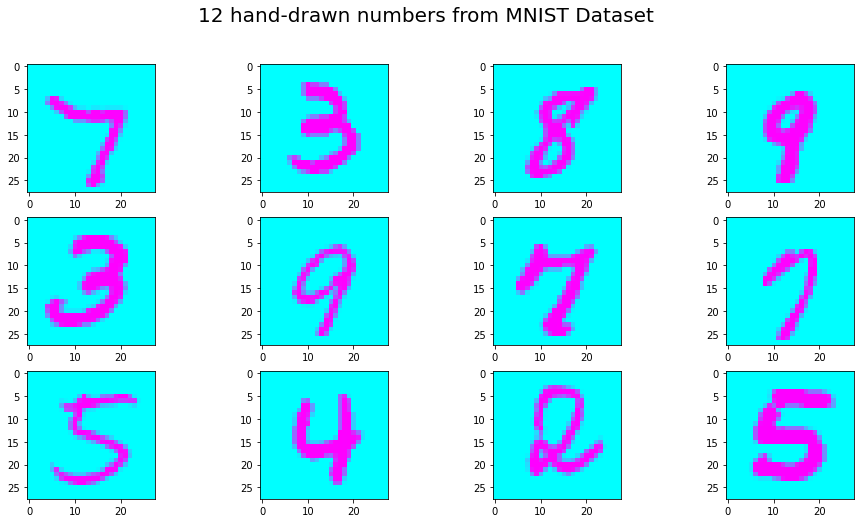

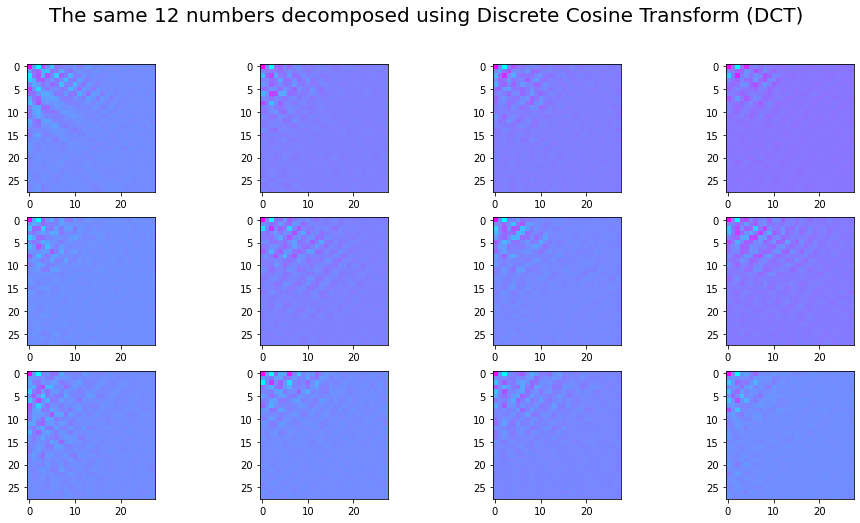

In [15]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn
from scipy.fftpack import dctn
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


def plot_images(images_ndarray, image_size, num_images, cmap, decomposed=False):
    """
    :param images_ndarray: numpy array of data representing images
    :param image_size: size of image to be reshaped; length x width are same value
    :param decomposed: boolean; true if you want to see the discrete cosine transform (DCT) decomposition of the image
    :return: matplotlib.pyplot implot of the reshaped matrix
    """
    col_count = 4
    if num_images % col_count == 0:
        row_count = int(num_images/col_count)
    else:
        row_count = int((num_images/col_count)+1)
    fig, axs = plt.subplots(row_count, col_count, figsize=(16, 8))

    if not decomposed:
        fig.suptitle(str(num_images) + ' hand-drawn numbers from MNIST Dataset', fontsize=20)
    else:
        fig.suptitle('The same ' + str(num_images) + ' numbers decomposed using Discrete Cosine Transform (DCT)', fontsize=20)

    # loop through each plot in the figure and add visual; rows then column
    image_index = 0
    for row in range(row_count):
        for col in range(col_count):
            if not decomposed:
                image = images_ndarray[image_index][:].reshape((image_size, image_size))
            else:
                image = dctn(images_ndarray[image_index][:].reshape((image_size, image_size)), norm='ortho')
            axs[row, col].imshow(image, cmap=cmap)
            image_index += 1
            if image_index >= images_to_plot:
                break
    plt.show()
    
# read in the data
(train_X, train_y), (test_X, test_y) = mnist.load_data()

images_to_plot = 12
# randomly select n number of images to plot
regular_cmap = 'cool'
decomposed_cmap = 'cool'
number_of_rows = train_X.shape[0]
np.random.seed(42)
random_indices = np.random.choice(number_of_rows, size=images_to_plot, replace=False)
random_rows = train_X[random_indices, :]
plot_images(random_rows, 28, images_to_plot, cmap=regular_cmap)
plot_images(random_rows, 28, images_to_plot, cmap=decomposed_cmap, decomposed=True)

### Here we are using the decomposed DCT image to apply diffferent 'masks' to the image. Each of the masks are the frequencies of the image we are focused on to generate features of the diagonal, vertical, and horizontal image frequencies. 

### By applying these masks, we can extract and reduce the number of features for each coefficient set (diag, vert, and horiz) by doing Principal component analysis (PCA) on the coefficient covariance matrix, then transpose the resulting matrix to get eigen vectors. Finally we will  select top n principal components from each PCA (n_components is an argument to the function).

In [16]:
def generate_features(datapoints, image_label, size, record_count, n_components=5):
    """
    Parameters
    ----------
    datapoints: np array of x datapoints
    image_label: np array of y datapoints; i.e. = the label of what the image is supposed to represent numerically
    size: pixel count for length/width
    record_count: # of records to sample

    Returns
    -------
    3 numpy arrays of the filtered image.
    """

    """This part is not needed"""
    # create n number of lists to keep track of image label indexes
    images = np.unique(image_label)
    image_count = len(images)
    image_indexes = [[] for i in range(0, image_count)]

    # loop through each image label and store the indexes in separate arrays based on the image class/label
    for i in range(len(image_label)):
        for j in range(image_count):
            if image_label[i] == images[j]:
                image_indexes[j].append(i)

    # DCT image mask arrays; each of the masks are the frequencies of the image we are focused on to generate features
    # of the diagonal, vertical, and horizontal image frequencies
    diag_mask = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
    diag_mask = np.array(diag_mask).reshape(28, 28)

    vert_mask = [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
    vert_mask = np.array(vert_mask).reshape((28, 28))

    horiz_mask = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
    horiz_mask = np.array(horiz_mask).reshape((28, 28))

    # arrays to keep track of features of each image
    data_diag = []
    data_vert = []
    data_horiz = []

    # loop through each of the records to generate features of each image
    for ind in range(record_count):
        # reshape the 1D array to 2D array given desired size (length x width)
        image = datapoints[ind].reshape((size, size))

        # get the dct image so we can multiply the decomposed image with the diagonal, vertical, horiztonal masks above
        # the masks are just the frequencies of the images we are processing
        # extract all non-zero values so we have the new total number of 'features' for each of the diag, vert, horiz
        dct_image = dctn(image, norm='ortho')

        dct_diag = dct_image * diag_mask
        data_diag.append(dct_diag[dct_diag != 0])  # appends all non-zero values

        dct_vert = dct_image * vert_mask
        data_vert.append(dct_vert[dct_vert != 0])

        dct_horiz = dct_image * horiz_mask
        data_horiz.append(dct_horiz[dct_horiz != 0])

    # reduce the number of features for each coefficient set (diag, vert, and horiz) by doing
    # PCA on the coefficient covariance matrix, then transpose the resulting matrix to get eigen vectors.
    # then select top n principal components from each PCA (n_components is an argument to the function)
    cov_diag = np.cov(np.array(data_diag).T)
    C_eigVecD = np.array(PCA().fit(cov_diag).components_.T)
    reduced_diag_data = pandas.DataFrame(np.matmul(np.array(data_diag), C_eigVecD[:, :n_components]))
    PC_diag_col_names = []
    for index in range(n_components):
        PC_diag_col_names.append('Diag_PC_' + str(index + 1))

    cov_vert = np.cov(np.array(data_vert).T)
    C_eigVecV = np.array(PCA().fit(cov_vert).components_.T)
    reduced_vert_data = pandas.DataFrame(np.matmul(np.array(data_vert), C_eigVecV[:, :n_components]))
    PC_vert_col_names = []
    for index in range(n_components):
        PC_vert_col_names.append('Vert_PC_' + str(index + 1))

    cov_horiz = np.cov(np.array(data_horiz).T)
    C_eigVecH = np.array(PCA().fit(cov_horiz).components_.T)
    reduced_horiz_data = pandas.DataFrame(np.matmul(np.array(data_horiz), C_eigVecH[:, :n_components]))
    PC_horiz_col_names = []
    for index in range(n_components):
        PC_horiz_col_names.append('Horiz_PC_' + str(index + 1))

    # add features from each PCA coefficient set with labels to a new dataframe pcaFeatures
    pca_features = pandas.DataFrame(image_label[:record_count])
    for index in range(n_components):
        pca_features['Diag_PC_' + str(index + 1)] = reduced_diag_data.iloc[:, index]
    for index in range(n_components):
        pca_features['Vert_PC_' + str(index + 1)] = reduced_vert_data.iloc[:, index]
    for index in range(n_components):
        pca_features['Horiz_PC_' + str(index + 1)] = reduced_horiz_data.iloc[:, index]
    return pca_features


### Below are the extracted features from each 'image'. The n_components argument is set to 20 so we will have the top 20 principal components (PC) from each of the diagonal, vertical, and horizontal portions of the decomposed image.

### We can use these PCs as the features of the images to classify them and see if the generated features can be used to separate each class.

### *** Note - we are doing this analysis by taking the first 1000 images. This is just a time saving measure for demo purposes since the original dataset contains over 42,000 images. ***

In [17]:
# Generate features for first 1000 images
reduced_data = generate_features(train_X, train_y, size=28, record_count=1000, n_components=20)
generate_features(train_X, train_y, size=28, record_count=1000, n_components=20)

,0,Diag_PC_1,Diag_PC_2,Diag_PC_3,Diag_PC_4,Diag_PC_5,Diag_PC_6,Diag_PC_7,Diag_PC_8,Diag_PC_9,...,Horiz_PC_11,Horiz_PC_12,Horiz_PC_13,Horiz_PC_14,Horiz_PC_15,Horiz_PC_16,Horiz_PC_17,Horiz_PC_18,Horiz_PC_19,Horiz_PC_20
0,5,103.341655,-64.395940,-186.597665,-212.936521,-258.960308,-258.015058,-428.603589,119.788694,-127.612826,...,-381.785273,-331.051556,128.413432,70.354052,196.767186,95.331067,-181.376244,148.552413,254.555451,-112.953624
1,0,376.083897,-690.407330,-271.933612,199.967572,-513.806424,299.726196,-155.491813,58.020877,37.211588,...,-284.331354,-95.234349,12.623856,-165.206935,83.556359,29.466550,-22.289831,-3.007082,34.795133,-56.755959
2,4,-230.686131,40.332225,-56.540707,87.741175,-5.807596,-210.655956,-60.791237,49.900898,46.146118,...,-165.221737,61.686060,73.689415,-190.049190,30.640404,-7.793770,-242.696606,68.327105,22.132200,13.213411
3,1,-715.220030,-161.302890,220.845650,45.103452,-238.274721,-145.849284,-63.924040,79.284767,6.139930,...,-49.729919,-77.563037,-53.474607,-1.264109,-13.733567,-19.623689,-179.094376,121.985788,21.855807,-32.428480
4,9,-84.404424,-46.243582,11.950996,456.807525,-444.238679,-24.511126,-96.362270,466.998793,-63.033204,...,-49.998166,59.843976,115.839854,-193.914220,-9.638179,-108.983835,-24.759766,-123.463054,-118.273852,27.931379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7,-236.155368,81.362294,-869.421376,-224.626202,-510.579402,-258.311447,51.303541,329.026916,-414.035514,...,-201.042895,-147.868127,117.978953,-325.349686,3.489490,-296.953940,81.562317,-0.367569,172.803407,260.832588
996,6,210.468827,62.705672,-174.242424,524.320487,-103.333854,-297.957074,-54.014780,202.778231,-84.871799,...,-222.250984,-32.935422,8.361287,178.788188,99.218122,-137.562730,-5.579467,87.821815,82.797909,6.665841
997,0,-365.461923,-1020.676143,-468.220188,-258.041278,329.798876,-79.410505,76.653853,277.029158,-20.742771,...,-204.854763,-49.344541,112.721107,-318.682757,-75.140322,-114.730862,-160.690519,126.417452,68.147872,20.832915
998,3,173.874533,-208.659379,172.553410,-271.431482,168.844077,80.366383,-241.062814,-165.712792,-127.972743,...,-70.964249,-119.766620,-232.390902,-121.613591,20.623503,-105.583404,-122.377559,-49.017288,29.676694,-62.645572


In [40]:
def rank_features_RFC(dataframe, label):
    """
    ranks a given set of features given as a dataframe; specify the label to rank by
    :param dataframe: pandas dataframe
    :param label: label is a string, it should be how we are classifying our data (ex: iris 'species')
    :return: a numpy matrix of all the features with their ranking from the given dataframe
    resource used: https://www.kaggle.com/dkim1992/feature-selection-ranking
    """
    # x-axis will be all features so we will drop the label
    x = dataframe.drop(label, axis=1)
    # y-axis is the label for the data analysis
    y = dataframe[label]

    # create a random forest for the data set for features of the label then add the feature_importance
    # importance of each to an array
    classifier = RandomForestClassifier().fit(x, y)
    rankings = []
    for index in range(len(x.columns)):
        rankings.append([x.columns[index], classifier.feature_importances_[index]])
    ranked_features = pandas.DataFrame(rankings, columns=['Feature', 'Explained Variance'])
    return ranked_features.sort_values(by='Explained Variance', ascending=False)


def plot_features(dataframe, label, feature_1, feature_2, feature_3=None, save_plot=False):
    """
    :param dataframe: pandas dataframe of input data
    :param label: label of the dataframe
    :param feature_1: feature 1 to plot on x xis
    :param feature_2: feature 2 to plot on y axis
    :param feature_3: optional feature 3 to plot on z axis
    :param save_plot: true/false to save the plot with the plot title as the file name; defaults to false
    :return: a plot of all classes in the dataframe
    """
    labels = dataframe[label].unique()
    labels.sort()
    classes = []
    for lbl in labels:
        classes.append(dataframe[dataframe[label] == lbl])

    # 2-D scatter plot for 2 features
    if feature_3 is None:
        fig = plt.figure(figsize=(10,10))
        for cls in classes:
            name = cls[label].unique()
            plt.scatter(cls[feature_1], cls[feature_2], label=name)
        plt.legend()
        plt.title(feature_1 + ' vs. ' + feature_2 + ' for labels ' + str(labels))
        plt.xlabel(feature_1)
        plt.ylabel(feature_2)
        if save_plot:
            plt.savefig(feature_1 + ' vs. ' + feature_2 + ' for labels ' + str(labels) + '.png')

    # 3-D plot plot for 3 features
    else:
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(projection='3d')
        for cls in classes:
            name = cls[label].unique()
            ax.scatter(cls[feature_1], cls[feature_2], cls[feature_3], label=name)
        plt.title(feature_1 + ' vs. ' + feature_2 + ' vs. ' + feature_3 + ' for labels ' + str(labels))
        ax.set_xlabel(feature_1)
        ax.set_ylabel(feature_2)
        ax.set_zlabel(feature_3)
        plt.legend()
        if save_plot:
            plt.savefig(feature_1 + ' vs. ' + feature_2 + 'vs. ' + feature_3 + ' for labels ' + str(labels) + '.png')

    return plt.show()

### Here we will use rank the top 20 principal components (PCs) from each DCT decomposition, then we will select the top 2 features for all numbers (classes) and display them as a 2-D scatter plot.

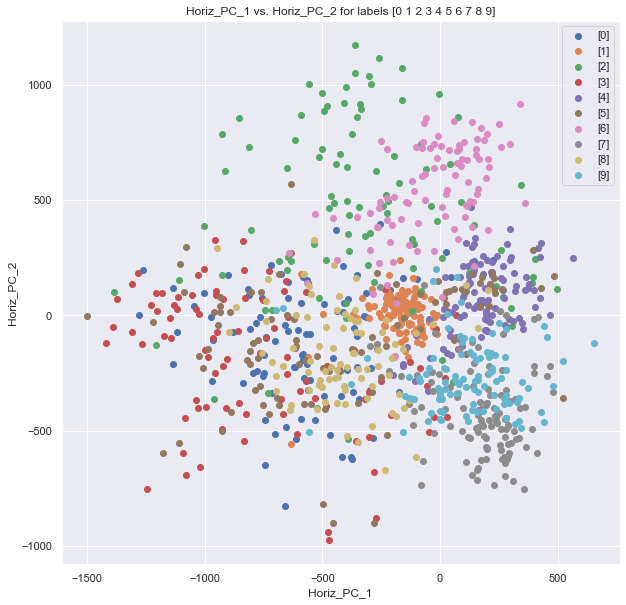

In [41]:
classifier_field = 0 # the name of the column holding the actual number of the hand written digit is labeled '0'
ranked_features = pandas.DataFrame(rank_features_RFC(reduced_data, classifier_field))

feature_1 = ranked_features.iloc[0, 0]
feature_2 = ranked_features.iloc[1, 0]
plot_features(reduced_data, classifier_field, feature_1, feature_2, save_plot=False)

### There isn't much separation in the data shown in the scatter plot above. This means that reducing the dataset to only 2 PCs is not very helpful for creating a classification of all numbers. However we can look at a subset of the numbers (e.g. 2, 3, 6, and 9) to see if we can distinguish between those numbers by using the top 2 PCs.


This is a 2-D Scatterplot of all 10 classes using the top 2 principal components.


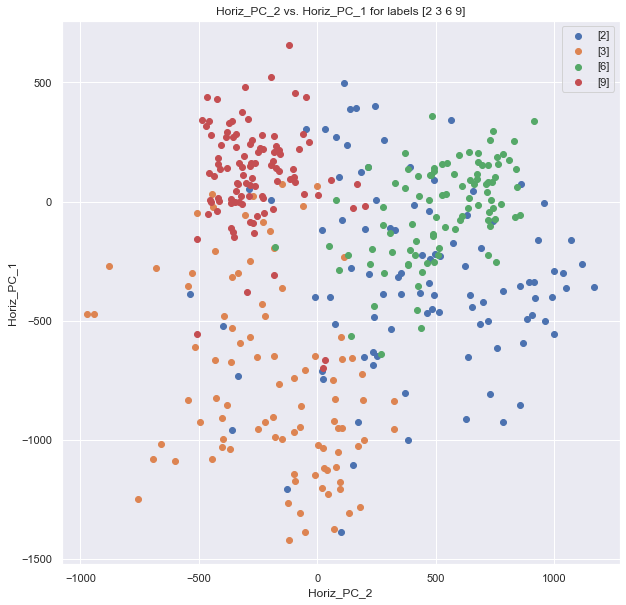

In [42]:
class_labels = [2, 3, 6, 9]
classes_to_plot = pandas.DataFrame(reduced_data.loc[reduced_data[classifier_field].isin(class_labels)])
ranked_features = rank_features_RFC(reduced_data, classifier_field)
feature_1 = ranked_features.iloc[0, 0]
feature_2 = ranked_features.iloc[1, 0]
print('\nThis is a 2-D Scatterplot of all 10 classes using the top 2 principal components.')
plot_features(classes_to_plot, classifier_field, feature_1, feature_2, save_plot=True)

### Since we narrowed down the dataset to only look at the hand drawn numbers 2, 3, 4, and 9, we can see there the separation between these classes is much more apparent. Next, we can create a Pairplot of these classes comparing the top 4 Principal Components. This plot shows all 4 features compared against one another. On the diagonal is the distribution of each feature separated in color by class.

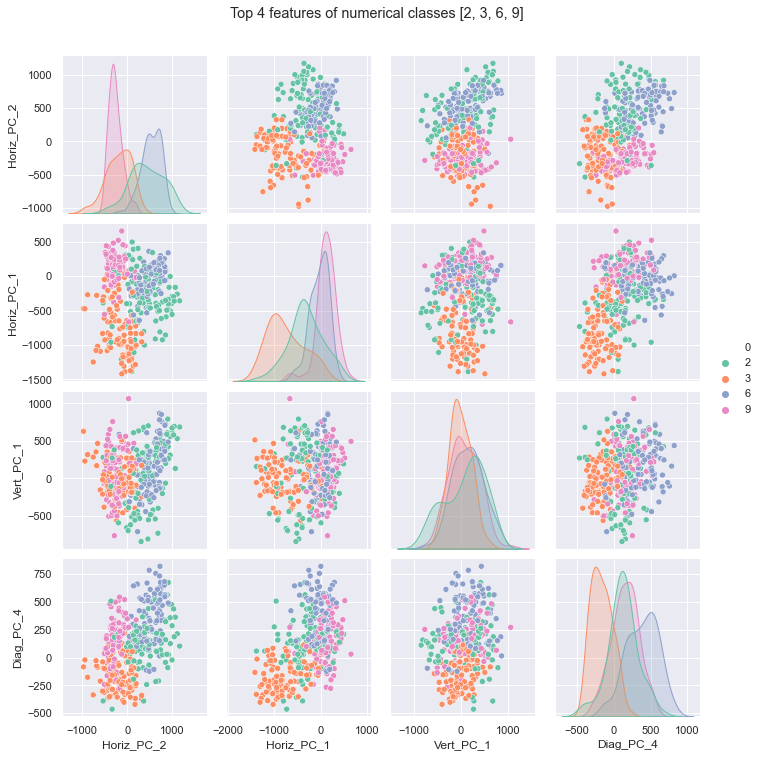

In [38]:
class_labels = [2, 3, 6, 9]
classes_to_plot = pandas.DataFrame(reduced_data.loc[reduced_data[classifier_field].isin(class_labels)])
ranked_features = rank_features_RFC(reduced_data, classifier_field)
feature_1 = ranked_features.iloc[0, 0]
feature_2 = ranked_features.iloc[1, 0]
feature_3 = ranked_features.iloc[2, 0]
feature_4 = ranked_features.iloc[3, 0]
data_to_plot = pandas.DataFrame()
data_to_plot[classifier_field] = classes_to_plot[classifier_field]
data_to_plot[feature_1] = classes_to_plot[feature_1]
data_to_plot[feature_2] = classes_to_plot[feature_2]
data_to_plot[feature_3] = classes_to_plot[feature_3]
data_to_plot[feature_4] = classes_to_plot[feature_4]
seaborn.set(font_scale=1)
seaborn.pairplot(data_to_plot, hue=classifier_field, palette='Set2').fig.suptitle(
    "Top 4 features of numerical classes " + str(class_labels), y=1.05)
plt.show()

### This shows a 3-D Plot of top 3 principal components for 3 most related classes (3, 6, and 9) which shows the separation of the each class the best. If we used this data to create a prediction model, there could be some potential of using these features to distinguish between the different hand drawn numbers from the dataset.

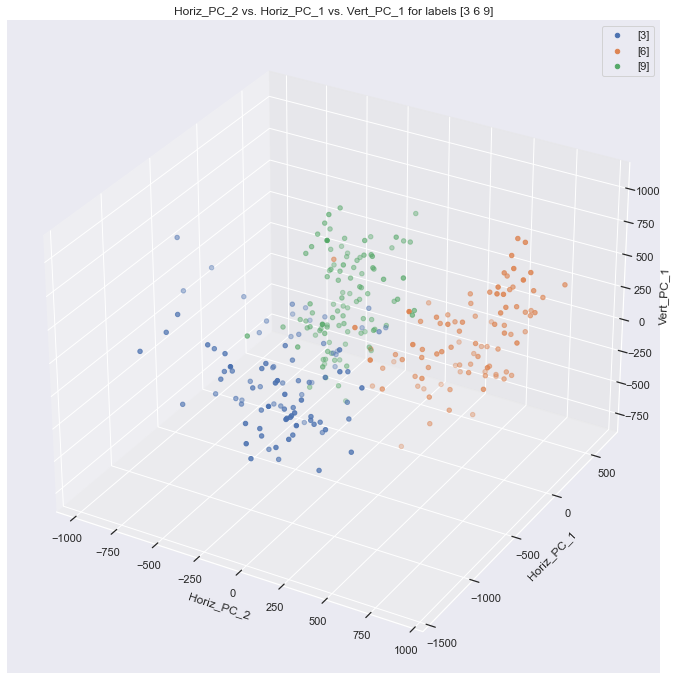

In [43]:
# only plot the classes below from the reduced dataset
class_labels = [3, 6, 9]
classes_to_plot = pandas.DataFrame(
    reduced_data.loc[reduced_data[classifier_field].isin(class_labels)])  # only plot the classes below from the reduced dataset

# rank features
ranked_features = rank_features_RFC(reduced_data, classifier_field)

# plot top 3 features
feature_1 = ranked_features.iloc[0, 0]
feature_2 = ranked_features.iloc[1, 0]
feature_3 = ranked_features.iloc[2, 0]
plot_features(classes_to_plot, classifier_field, feature_1, feature_2, feature_3, save_plot=True)